In [1]:
import pandas as pd

# Load the cleaned data
df_sql = pd.read_csv("df_clean_for_sql.csv")

# Load readmission flag data, exported from SQL
# If you want, we can re-compute it in Python for consistency
df_sql['readmit_30_flag'] = df_sql['readmitted'].apply(lambda x: 1 if x == '<30' else 0)

print(df_sql.shape)
df_sql.head()

(101766, 54)


/var/folders/80/qns4qhrj56lg74phvxs3sj0r0000gn/T/ipykernel_3700/2688484676.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df_sql = pd.read_csv("df_clean_for_sql.csv")


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,glimepiride_pioglitazone,metformin_rosiglitazone,metformin_pioglitazone,change,diabetesmed,readmitted,admission_type_desc,discharge_disposition_desc,admission_source_desc,readmit_30_flag
0,12522,48330783,Caucasian,Female,[80-90),NaN,2,1,4,13,...,No,No,No,Ch,Yes,NO,Urgent,Discharged to home,Transfer from a hospital,0
1,15738,63555939,Caucasian,Female,[90-100),NaN,3,3,4,12,...,No,No,No,Ch,Yes,NO,Elective,Discharged/transferred to SNF,Transfer from a hospital,0
2,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,...,No,No,No,Ch,Yes,NO,Emergency,Discharged to home,Emergency Room,0
3,28236,89869032,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,...,No,No,No,No,Yes,>30,Emergency,Discharged to home,Emergency Room,0
4,35754,82637451,Caucasian,Male,[50-60),NaN,2,1,2,3,...,No,No,No,No,Yes,>30,Urgent,Discharged to home,Clinic Referral,0


In [2]:
import numpy as np

def icd9_category(code):
    """
    Convert ICD-9 code to category.
    Handles numeric, V-codes, and E-codes.
    """
    if pd.isna(code):
        return "Unknown"
    
    code_str = str(code)

    # V-codes (factors influencing health)
    if code_str.startswith("V"):
        return "Supplemental"

    # E-codes (external causes of injury)
    if code_str.startswith("E"):
        return "External Causes"

    # Try numeric conversion
    try:
        numeric = float(code_str)
    except:
        return "Unknown"

    # Mapping based on ICD-9 chapters
    if 390 <= numeric <= 459:
        return "Circulatory"
    elif 460 <= numeric <= 519:
        return "Respiratory"
    elif 520 <= numeric <= 579:
        return "Digestive"
    elif 580 <= numeric <= 629:
        return "Genitourinary"
    elif 250.0 <= numeric <= 250.99:
        return "Diabetes"
    elif 780 <= numeric <= 799:
        return "Symptoms"
    elif 800 <= numeric <= 999:
        return "Injury/Poisoning"
    else:
        return "Other"

# Apply to diag columns
df_sql['diag_1_cat'] = df_sql['diag_1'].apply(icd9_category)
df_sql['diag_2_cat'] = df_sql['diag_2'].apply(icd9_category)
df_sql['diag_3_cat'] = df_sql['diag_3'].apply(icd9_category)

print(df_sql[['diag_1', 'diag_1_cat']].head(10))

  diag_1   diag_1_cat
0    398  Circulatory
1    434  Circulatory
2    197        Other
3  250.7     Diabetes
4    414  Circulatory
5    157        Other
6    428  Circulatory
7    428  Circulatory
8    414  Circulatory
9    518  Respiratory


In [3]:
# Readmission rate by primary diagnosis category
diagnosis_summary = (
    df_sql.groupby('diag_1_cat')
    .agg(
        total_cases=('diag_1_cat', 'size'),
        readmissions_30=('readmit_30_flag', 'sum')
    )
    .assign(
        readmission_rate=lambda x: round(100 * x['readmissions_30'] / x['total_cases'], 2)
    )
    .sort_values('readmission_rate', ascending=False)
)

diagnosis_summary

,total_cases,readmissions_30,readmission_rate
diag_1_cat,,,
Unknown,21,5,23.81
Supplemental,1644,266,16.18
Diabetes,8757,1137,12.98
Injury/Poisoning,6974,854,12.25
Circulatory,30336,3474,11.45
Genitourinary,5078,549,10.81
Respiratory,10407,1112,10.69
Other,21704,2307,10.63
Digestive,9208,966,10.49


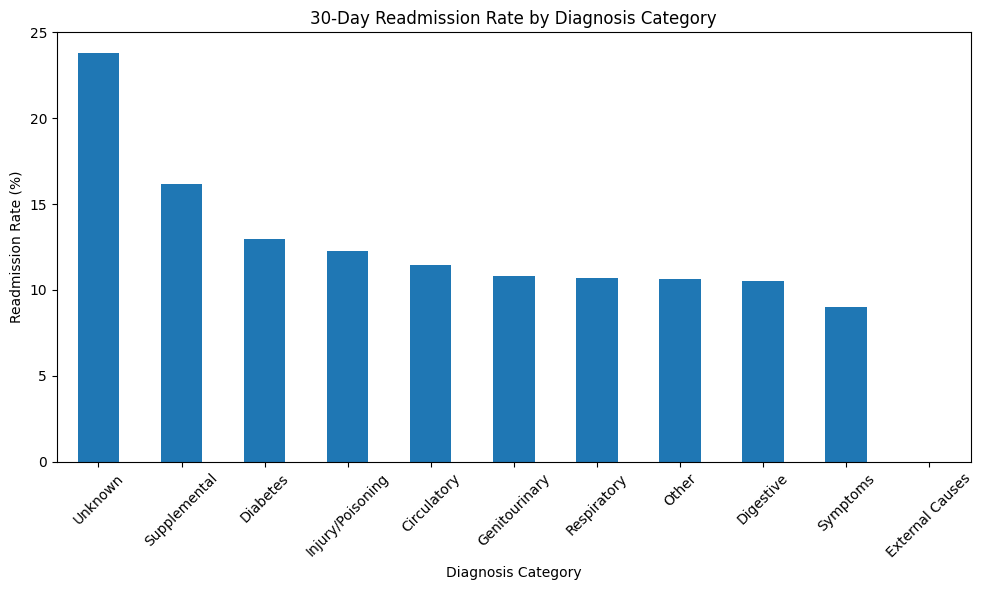

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

diagnosis_summary['readmission_rate'].plot(
    kind='bar',
    xlabel='Diagnosis Category',
    ylabel='Readmission Rate (%)',
    title='30-Day Readmission Rate by Diagnosis Category'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

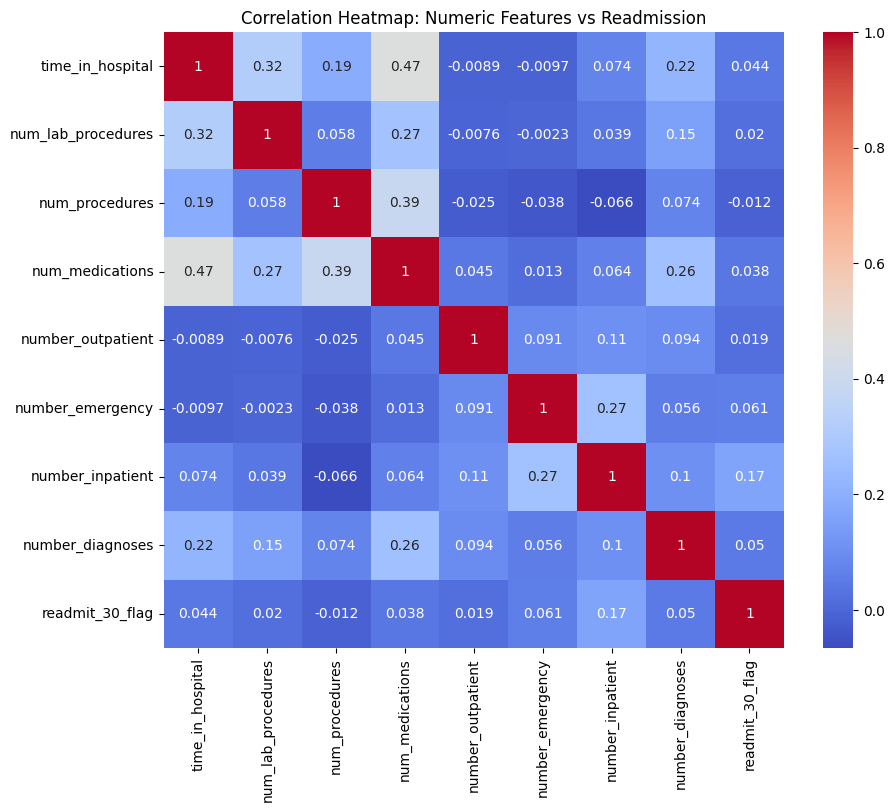

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select numeric columns for correlation
numeric_cols = [
    'time_in_hospital', 'num_lab_procedures', 'num_procedures',
    'num_medications', 'number_outpatient', 'number_emergency',
    'number_inpatient', 'number_diagnoses', 'readmit_30_flag'
]

corr = df_sql[numeric_cols].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap: Numeric Features vs Readmission')
plt.show()